<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Intro to Machine Learning Based Strategies

This work aims to create and test investment strategies based on machine learning (ML) techniques. In this case, the forecasts are based on the Microsoft stock price and returns. We use regression techniques (predicting exact numbers) and classification techniques.

## Importing the required libraries

First, we begin by importing the libraries we used across the code. 
- `Yfinance` to download the daily prices from yahoo finance.
- `Numpy` and `Pandas` to manipulate the data.
- `Matplotlib` and `Seaborn` to create the charts
- `Scikit-learn` to implement machine learning models

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import linear_model

### Graph Formating

In [16]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

## Downloading the Data

The next step is to download the Microsoft (MSFT) historical price from Yahoo Finance. The window used is daily data from Jan-2010 to Dec-2019.

In [17]:
symbol = ["MSFT"]
rawdata = yf.download(symbol, start="2010-01-01", end="2019-12-31")
rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

[*********************100%***********************]  1 of 1 completed


To have a first insight into the data, we proceed to create a line chart with the downloaded price. We can tell that the stock has a positive trend across the nine years analyzed, and it seems to follow an exponential growth pattern.

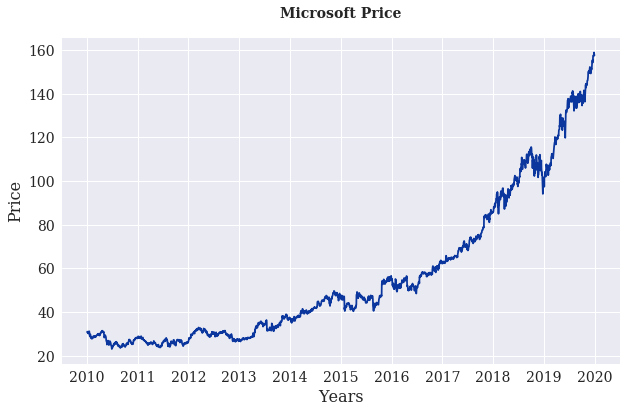

In [18]:
plt.figure()
plt.title('Microsoft Price',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Price')
plt.plot(rawdata, color='#0A369D');
# plt.savefig('price.png', facecolor='None')

## Univariate Linear Regression Model

To begin with the predictions, we started by utilizing a simple linear regression model. In this example, we look for a relationship between the MSFT price and the time variable. As a result of the visual inspection, we created a two-degree linear model that emulates the exponential growth that we mentioned before.

At the moment of forecasting, it is a good practice to split the data into training and test to validate the prediction with unknown inputs and not utilize the same ones that we used to create the model.

In [19]:
LR = rawdata.copy()
LR['indx'] = np.arange(len(LR))

split = int(len(LR) * 0.8)
LR_train, LR_test = LR[:split], LR[split:]

X_test  = LR_test['indx'].values
X_train = LR_train['indx'].values
y_train = LR_train['price'].values

reg = np.polyfit(X_train, y_train, deg=2)
np.set_printoptions(suppress=True)
reg

array([ 0.00001691, -0.00930968, 28.0186525 ])

Once we fitted the data to a polynomial function with `polyfit`, we proceeded to represent the function graphically for the whole dataset. As we can appreciate, the linear regression fits quite well with the training set. However, at the moment of representing the test set (shaded area), it does not does a good job.

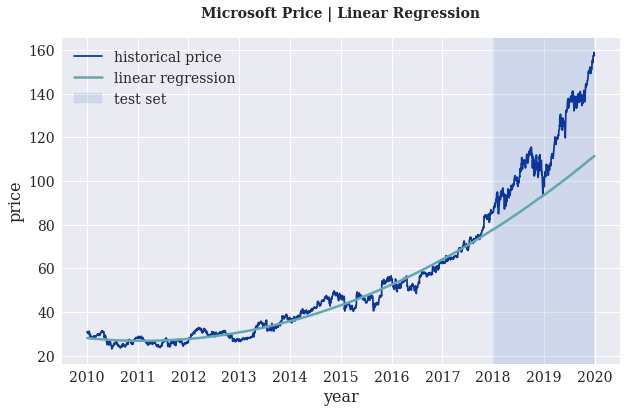

In [20]:
fig = plt.figure()
ax = plt.axes()
ax.plot(LR.index,LR['price'],label='historical price', color='#0A369D')
ax.plot(LR.index, np.polyval(reg, LR['indx']), lw=2.5,
         label='linear regression', color='#62a8ac')
ax.axvspan(LR.index[split], LR.index[len(LR)-1], alpha=0.25, color='#80A1D4', label='test set')
ax.set_title('Microsoft Price | Linear Regression',fontweight="bold", pad=20)
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.legend(loc=0);
# plt.savefig('price_regression.png', facecolor='None')

## Multivariate Linear Regression Model (price prediction)

One way of improving the previous function is to regress the stock price with respect to it's own lags. As we can see in the following table we created 5 lags for each observation (and discarded the NA observations).

In [21]:
lagsR = rawdata.copy()

lags = 5 ;cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    lagsR[col] = lagsR['price'].shift(lag)
    cols.append(col)
lagsR.dropna(inplace=True)

In [22]:
lagsR.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,30.270000,30.660000,30.450001,30.770000,30.959999,30.950001
2010-01-12,30.070000,30.270000,30.660000,30.450001,30.770000,30.959999
2010-01-13,30.350000,30.070000,30.270000,30.660000,30.450001,30.770000
2010-01-14,30.959999,30.350000,30.070000,30.270000,30.660000,30.450001
2010-01-15,30.860001,30.959999,30.350000,30.070000,30.270000,30.660000


Before creating the new model, we inspect the generated data through a correlation matrix. As we can appreciate in the table below, all the values are close to one. aThis means that the lags are highly correlated to each other. As a consequence, linear regression is probably not the best method to predict the price because one of the model's assumptions is that the variables are independent.

In [23]:
a = lagsR[cols].corr()
a.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,1.000,0.999,0.999,0.999
lag_2,1.000,1.000,1.000,0.999,0.999
lag_3,0.999,1.000,1.000,1.000,0.999
lag_4,0.999,0.999,1.000,1.000,1.000
lag_5,0.999,0.999,0.999,1.000,1.000


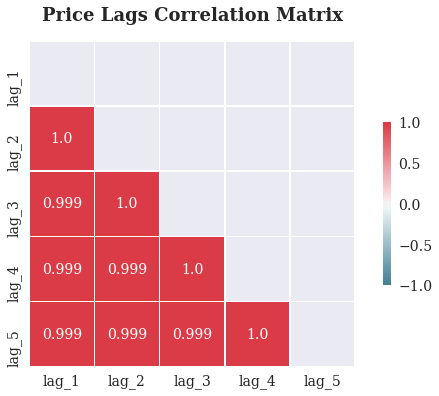

In [24]:
mask = np.triu(np.ones_like(a, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(a, mask=mask,  cmap=cmap,  annot=True,fmt=".3", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Price Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('price_corr.png', facecolor='None')

The next step is to implement a multivariate regression of the stock price with respect to the 5 lags. This time we utilize the `numpy` function `linalg.lstsq` that approximates the solution of a linear matrix equation using least squares. From the results we can see that the first lag strictly dominates the model to the other lags.

In [51]:
reg = np.linalg.lstsq(lagsR[cols], lagsR['price'],
                      rcond=None)[0]

lagsR['prediction'] = np.dot(lagsR[cols], reg)

reg

array([ 0.89973819,  0.00392316,  0.12565959, -0.07934974,  0.05130533])

If we represent the results graphically for the entire period, we can not see the prediction line because it is overlapped with the original price series. If we zoom in for the last 3 months of observations, we can see that the model predicts the next price observation as the same observation that we have today. So basically, the prediction series is the same one than the original price shifted by one day.


In statistical terms, we can not predict the stock price because the series is non-stationary. To solve this, we can take differences of the variable and predict them; in other words, we try to predict the daily returns instead of the stock price.

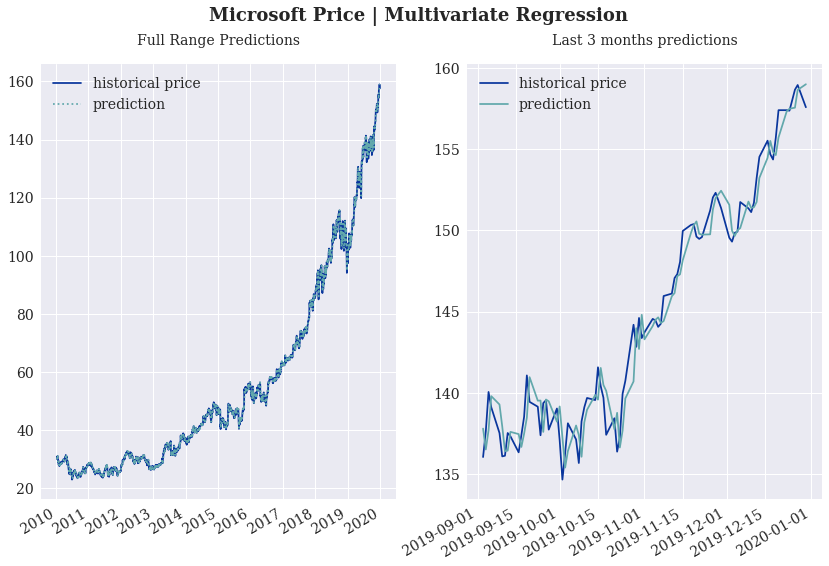

In [26]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.plot(lagsR.index, lagsR['price'], label='historical price', color='#0A369D')
plt.plot(lagsR.index, lagsR['prediction'], label='prediction', linestyle=':', color='#62a8ac')
plt.title('Full Range Predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');

plt.subplot(1,2,2)
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['price'].loc['2019-9-1':],
         label='historical price', color='#0A369D')
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['prediction'].loc['2019-9-1':],
         label='prediction', linestyle='-', color='#62a8ac')
plt.title('Last 3 months predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right')
plt.suptitle("Microsoft Price | Multivariate Regression",fontweight="bold");
# plt.savefig('price_multi.png', facecolor='None')

## Multivariate Linear Regression Model (returns prediction)

As we discussed before, now we proceed to calculate the logarithmic returns of the MSFT stock price. The log-returns are stationary, this means that they dont have a linear trend (mean is constant over time). After that, we recalculate the 5 lags, as we show in the table below.

In [27]:
rets = rawdata.copy()
rets['returns'] = np.log(rets/rets.shift(1))

lags = 5; cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    rets[col] = rets['returns'].shift(lag)
    cols.append(col)
rets.dropna(inplace=True)

rets.head()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2010-01-12,30.070000,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,0.000323
2010-01-13,30.350000,0.009269,-0.006629,-0.012802,0.006873,-0.010454,-0.006156
2010-01-14,30.959999,0.019899,0.009269,-0.006629,-0.012802,0.006873,-0.010454
2010-01-15,30.860001,-0.003235,0.019899,0.009269,-0.006629,-0.012802,0.006873
2010-01-19,31.100000,0.007747,-0.003235,0.019899,0.009269,-0.006629,-0.012802


We implement the correlation matrix again to confirm if the new lags are independent. The values of the table are now close to 0. The analysis confirms that differencing the time series solved the problem of dependence, and we can then model the series.

In [28]:
b = rets[cols].corr()
b.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,-0.035,-0.022,0.005,-0.037
lag_2,-0.035,1.000,-0.035,-0.022,0.005
lag_3,-0.022,-0.035,1.000,-0.035,-0.022
lag_4,0.005,-0.022,-0.035,1.000,-0.035
lag_5,-0.037,0.005,-0.022,-0.035,1.000


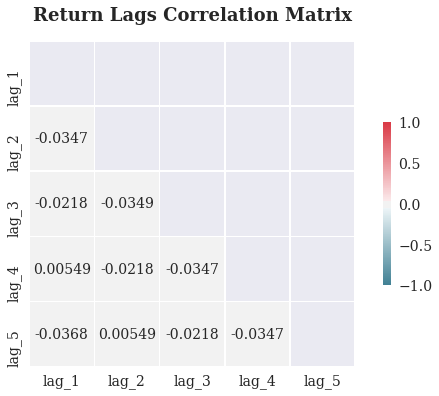

In [29]:
mask = np.triu(np.ones_like(b, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(b, mask=mask, cmap=cmap ,  annot=True ,fmt=".3",vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Return Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('returns_corr.png', facecolor='None')

We proceed to estimate the linear regression again with `linalg.lstsq`. We can appreciate from the resulting coefficients that there isn't a single lag that dominates the rest of the lags.

In [53]:
reg = np.linalg.lstsq(rets[cols], rets['returns'],rcond=None)[0]

rets['prediction'] = np.dot(rets[cols], reg)

reg

array([-0.03467407, -0.02135581,  0.00374165, -0.03650272, -0.05466607])

The next step is to represent the new model and the original return series graphically. We can see that the time series hasn't had a trend due to the difference that we applied before.

Another conclusion that we can make looking at the chart is that the multivariate regression does not capture the variance of the original series. The historical return has movements larger than 5%, while the prediction returns are lower than 1%.

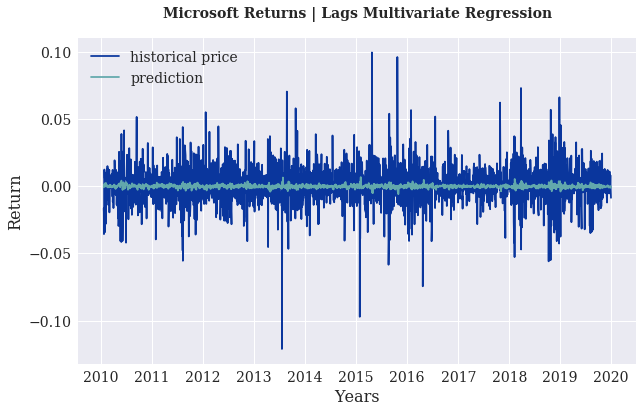

In [32]:
plt.figure()
plt.title('Microsoft Returns | Lags Multivariate Regression',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Return')
plt.plot(rets['returns'].iloc[lags:], label='historical returns', color='#0A369D')
plt.plot(rets['prediction'].iloc[lags:], label='prediction', color='#62a8ac')
plt.legend(loc=0);
# plt.savefig('returns_multi.png', facecolor='None')

As we did for our first model, we proceed to split the data between train and test sets so we can have more relevant backtesting.

In [33]:
cutoff = '2018-1-1'
train = rets[rets.index < cutoff].copy()
test = rets[rets.index >= cutoff].copy()

In [34]:
reg = np.linalg.lstsq(train[cols], train['returns'],
                      rcond=None)[0]
reg

array([ 0.00177352,  0.01168872, -0.02328992, -0.03026865, -0.03686199])

Given that for our vectorized backtesting we need to predict the right direction of the market and not the specific return, we proceed to measure the number of correct hits of the new model.

In [35]:
test['prediction'] = np.dot(test[cols], reg)

test['prediction'] = np.sign(test['prediction'])

For the multivariate lag regression of the returns, we correctly classified 260 returns, resulting in a hit ratio of 51.79%. This means that we accurately assessed the direction of the market in more than half of the test set's observations.

In [37]:
hits = np.sign(test['returns'] *
               test['prediction']).value_counts()
hits

 1.0    260
-1.0    239
 0.0      3
dtype: int64

In [38]:
hits.values[0] / sum(hits)

0.5179282868525896

The next step is to create an algorithmic strategy with the model that goes longs if it predicts a positive return and short if it forecasts a negative one.

In [39]:
test['strategy'] = test['prediction'] * test['returns']

Representing the result of the strategy graphically, we can see that even though the model accurately predicts the direction of the markets (most of the time) it isn't enough to create a positive alpha (over-return) vs investing directly in the MSFT stock.

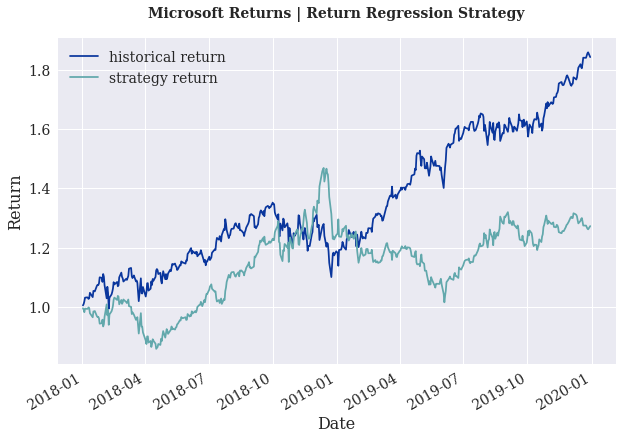

In [40]:
plt.figure()
plt.title('Microsoft Returns | Return Regression Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(test['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(test['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('regression_strategy.png', facecolor='None')

## Logistic Regression Model (returns prediction)

To improve the previous results, we implemented a __Logistic Regression__ model that was specifically created to solve classifying problems. In our example, the model tries to classify the next return into a positive or negative one.

To implement this model, we use the package `Scikit Learn`, a specialized machine learning library. Building on top of the previous examples, we split the data in train/test and try to predict the difference of the prices(returns) with the last 5 lags.

In [41]:
cutoff = '2018-1-1'
train = rets[rets.index < cutoff].copy()
test = rets[rets.index >= cutoff].copy()

lm = linear_model.LogisticRegression(C=1e6, solver='lbfgs',
                                     multi_class='auto')
lm.fit(train[cols], np.sign(train['returns']))

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
test['prediction'] = lm.predict(test[cols])

The Logistic Regression now predicts 273 returns correctly (vs 260 of the Multivariate Regression). With a hit ratio of 55.38% (vs 51.79%). We can conclude that the classifier model did a better job than the previous model at the moment of predicting the sign of the next return.

In [44]:
hits = np.sign(test['returns'].iloc[lags:] *
               test['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    273
-1.0    221
 0.0      3
dtype: int64

In [45]:
accuracy_score(test['prediction'],
               np.sign(test['returns']))

0.5537848605577689

Even though we have a better model, we have to check if it derives in a positive strategy when investing. For that, we proceed to create the variable strategy (for the test dataset) that it goes long and short according to the predictions.

In [46]:
test['strategy'] = test['prediction'] * test['returns']

Our final step would be to chart the cumulative returns of the new Logistic Regression model vs the performance of the original stock. As we can see in the graph, this time, the strategy provides a positive alpha. It offered a better return than the original MSFT stock for the period analyzed.

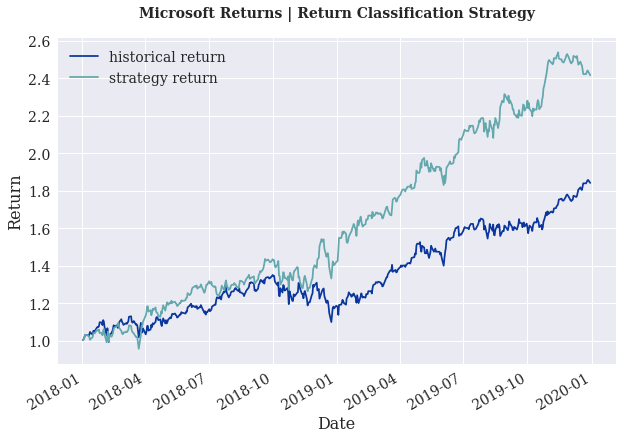

In [47]:
plt.figure()
plt.title('Microsoft Returns | Return Classification Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(test['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(test['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('classification_strategy.png', facecolor='None')

## Conclusion

Throughout this example, we have implemented many forecasting models that helped us better grasp how the financial variables behave and which is the best way to model them. With the implemented corrections, we achieved a model that provides extra returns for the Microsoft stock for the period analyzed. Nevertheless, we have to bear in mind that this is a lab situation. We did not take into account transactional costs and that through vectorized backtesting, and we already had the whole dataset (something that doesn't apply in real life).

The next step to improve the modelling of trading strategies would be to implement neuronal networks. This methodology has proven to be effective at the moment of forecasting financial series.

## References

Inspired by the book *Artificial Intelligence for Finance* by Yves Hilpisch.

<img src="https://images-na.ssl-images-amazon.com/images/I/51VEL0RZbzL._SX379_BO1,204,203,200_.jpg" width="250" style="float:left">

and the *University Certificate in Python for Algorithmic Trading*

<img src="https://home.tpq.io/wp-content/uploads/2019/11/algo_broch_cov_shadow.png" width="250" style="float:left">

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>